# Importing Packages 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime
import random

from tensorflow import keras
from keras.models import Input, Model, Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping

# Reading the Data 

In [2]:
import os

training_files = []
for (dirpath, dirnames, filenames) in os.walk('/content/training_data'):
    for filename in filenames:
        training_files.append(f'{dirpath}/{filename}')

In [3]:
df = pd.DataFrame()
for file_path in training_files:
    tmp = pd.read_csv(file_path)
    tmp['time'] = pd.to_datetime(tmp['time'])
    tmp['diff'] = tmp['generation'] - tmp['consumption']
    df = df.append(tmp)

In [4]:
df

,time,generation,consumption,diff
0,2018-01-01 00:00:00,0.00,2.52,-2.52
1,2018-01-01 01:00:00,0.73,1.44,-0.71
2,2018-01-01 02:00:00,0.00,2.79,-2.79
3,2018-01-01 03:00:00,0.00,2.83,-2.83
4,2018-01-01 04:00:00,0.00,2.85,-2.85
...,...,...,...,...
5827,2018-08-31 19:00:00,0.06,1.14,-1.08
5828,2018-08-31 20:00:00,0.01,1.48,-1.47
5829,2018-08-31 21:00:00,0.01,2.01,-2.00
5830,2018-08-31 22:00:00,0.01,1.82,-1.81


# Data Cleaning 

In [5]:
df = df.groupby('time')['generation', 'consumption', 'diff'].mean()
df.reset_index(inplace=True)
df.sort_values('time', inplace=True)

df['date'] = [timestamp.date() for timestamp in df['time']]
df['hour'] = [timestamp.hour for timestamp in df['time']]
df['month'] = [timestamp.month for timestamp in df['time']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [6]:
df

,time,generation,consumption,diff,date,hour,month
0,2018-01-01 00:00:00,0.0902,1.1864,-1.0962,2018-01-01,0,1
1,2018-01-01 01:00:00,0.2922,1.1902,-0.8980,2018-01-01,1,1
2,2018-01-01 02:00:00,0.0048,1.0028,-0.9980,2018-01-01,2,1
3,2018-01-01 03:00:00,0.0776,1.0000,-0.9224,2018-01-01,3,1
4,2018-01-01 04:00:00,0.0776,0.9604,-0.8828,2018-01-01,4,1
...,...,...,...,...,...,...,...
5827,2018-08-31 19:00:00,0.1636,3.3578,-3.1942,2018-08-31,19,8
5828,2018-08-31 20:00:00,0.0070,2.7128,-2.7058,2018-08-31,20,8
5829,2018-08-31 21:00:00,0.0032,2.8818,-2.8786,2018-08-31,21,8
5830,2018-08-31 22:00:00,0.0036,3.3230,-3.3194,2018-08-31,22,8


# Data Analysis 

In [7]:
df.describe()

,generation,consumption,diff,hour,month
count,5832.000000,5832.000000,5832.000000,5832.00000,5832.000000
mean,0.780644,1.444440,-0.663796,11.50000,4.526749
std,1.117562,0.879626,1.190230,6.92278,2.295815
min,0.002000,0.357000,-3.990400,0.00000,1.000000
25%,0.004600,0.758200,-1.258050,5.75000,3.000000
50%,0.060200,1.148500,-0.697100,11.50000,5.000000
75%,1.294400,1.950450,-0.223600,17.25000,7.000000
max,4.028600,4.660600,3.308200,23.00000,8.000000


## Hourly data 

In [8]:
df_hourly_trend = df.groupby('hour').mean()

Text(0, 0.5, 'kWh')

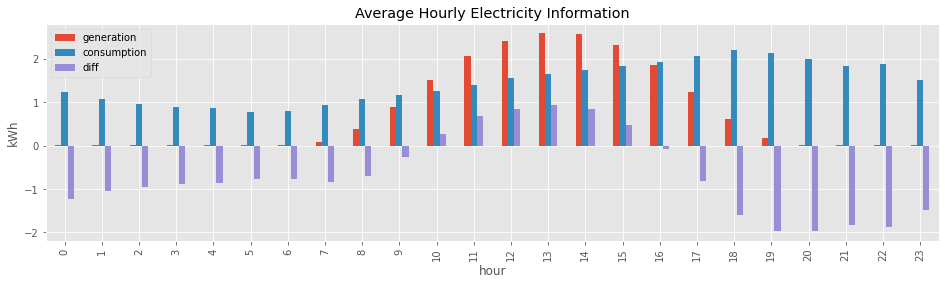

In [9]:
plt.style.use('ggplot')
df_hourly_trend[['generation', 'consumption', 'diff']].plot.bar(figsize=(16, 4))
plt.title('Average Hourly Electricity Information')
plt.ylabel('kWh')

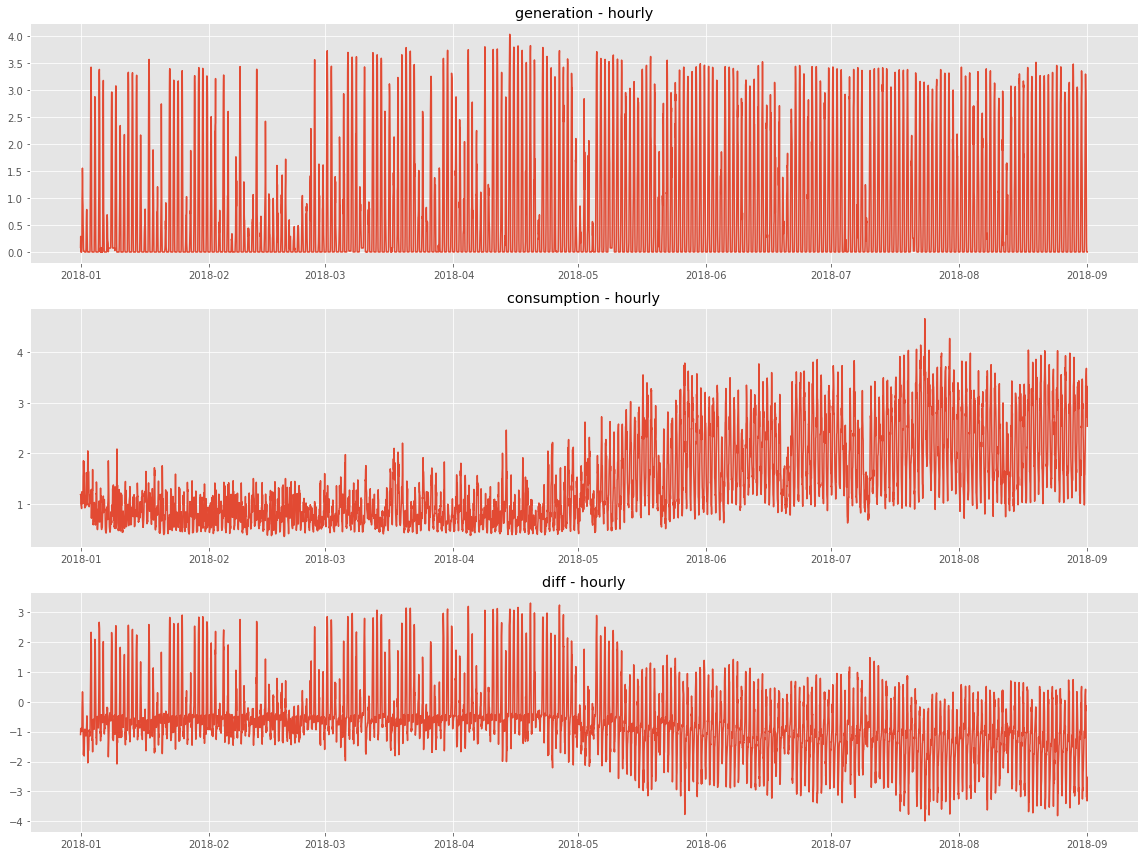

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 12))

for i, feature in enumerate(['generation', 'consumption', 'diff']):
    axes[i].plot('time', feature, data=df)
    axes[i].set_title(f'{feature} - hourly')
        
plt.tight_layout()
plt.show()

## Daily data 

In [11]:
df_daily_trend = df.groupby('date').mean()

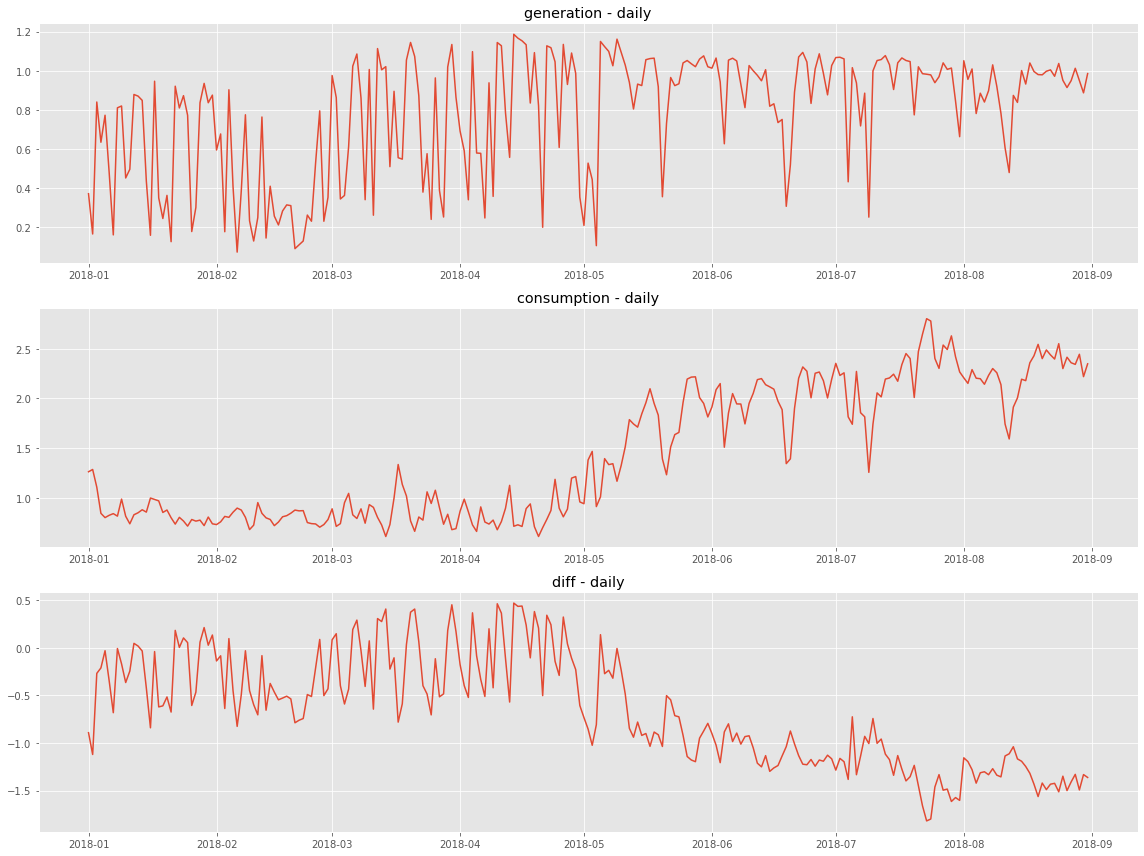

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 12))

for i, feature in enumerate(['generation', 'consumption', 'diff']):
    axes[i].plot(df_daily_trend.index, feature, data=df_daily_trend)
    axes[i].set_title(f'{feature} - daily')
        
plt.tight_layout()
plt.show()

# Feature Engineering

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


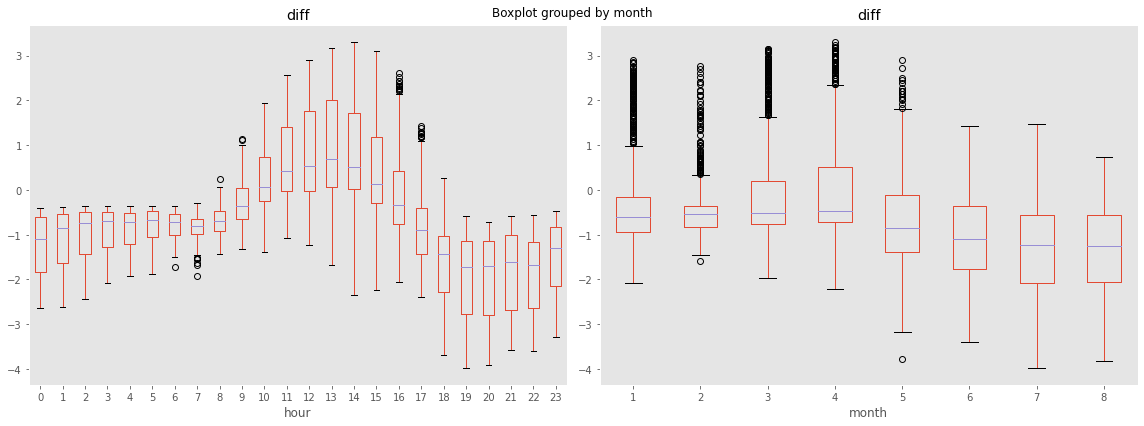

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

df.boxplot('diff', by='hour', figsize=(16, 8), grid=False, ax=axes[0])
df.boxplot('diff', by='month', figsize=(16, 8), grid=False, ax=axes[1])

plt.tight_layout()
plt.show()

In [14]:
# Creating the cyclical daily feature
list_cos_hourly = [np.cos(x * (2 * np.pi / 24)) for x in df['hour']]
list_sin_hourly = [np.sin(x * (2 * np.pi / 24)) for x in df['hour']]
df['hour_index'] = list(map(lambda x, y: x + y, list_cos_hourly, list_sin_hourly))

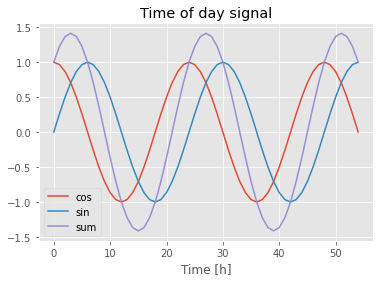

In [15]:
# Ploting the first 55 hours
plt.plot(list_cos_hourly[:55], label='cos')
plt.plot(list_sin_hourly[:55], label='sin')
plt.plot(np.array(df['hour_index'])[:55], label='sum')
plt.xlabel('Time [h]')
plt.title('Time of day signal')
plt.legend()
plt.show()

In [16]:
# Creating the cyclical yearly feature
sec_in_a_year = 365.25 * 24 * 60 * 60
list_cos_monthly = [np.cos(x.timestamp() * (2 * np.pi / sec_in_a_year)) for x in df['time']]
list_sin_monthly = [np.sin(x.timestamp() * (2 * np.pi / sec_in_a_year)) for x in df['time']]
df['month_index'] = list(map(lambda x, y: x + y, list_cos_monthly, list_sin_monthly))

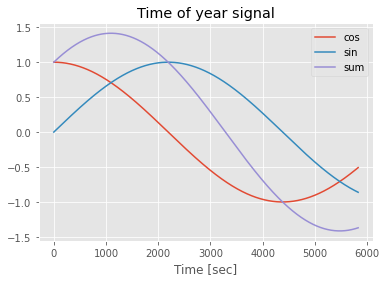

In [17]:
# Ploting the first year
plt.plot(list_cos_monthly, label='cos')
plt.plot(list_sin_monthly, label='sin')
plt.plot(np.array(df['month_index']), label='sum')
plt.xlabel('Time [sec]')
plt.title('Time of year signal')
plt.legend()
plt.show()

In [18]:
df.drop(['time', 'generation', 'consumption',	'date',	'hour',	'month'], axis=1, inplace=True)

In [19]:
df

,diff,hour_index,month_index
0,-1.0962,1.000000e+00,1.000000
1,-0.8980,1.224745e+00,1.000717
2,-0.9980,1.366025e+00,1.001433
3,-0.9224,1.414214e+00,1.002148
4,-0.8828,1.366025e+00,1.002863
...,...,...,...
5827,-3.1942,-7.071068e-01,-1.370384
5828,-2.7058,-3.660254e-01,-1.370133
5829,-2.8786,-3.330669e-16,-1.369882
5830,-3.3194,3.660254e-01,-1.369630


# Pre-*processing*

## Scaler function

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

def normalize(data):
  norm_arr = scaler.fit_transform(data)
  return norm_arr

def inverse_normalize(data):
  return scaler.inverse_transform(data)

## Hyper parameters

In [21]:
n_lag = 24 * 7
n_ahead = 24
target_index = df.columns.get_loc('diff')

# Share of obs in testing 
test_share = 0.05
epochs = 300
batch_size = 512
lr = 0.001

# Number of neurons in LSTM layer
n_layer = 10

## Creating the training matrices

In [22]:
def create_X_Y(data: np.array, n_lag, n_ahead, target_index) -> tuple:
  
    X, Y = [], []
    for i in range(len(data) - n_lag - n_ahead):
        Y.append(data[(i + n_lag):(i + n_lag + n_ahead), target_index])
        X.append(data[i:(i + n_lag)])
        
    X, Y = np.array(X), np.array(Y)
    X = np.reshape(X, (X.shape[0], n_lag, data.shape[1]))
    return X, Y

In [23]:
nrows = df.shape[0]
train = df[0:int(nrows * (1 - test_share))]
test = df[int(nrows * (1 - test_share)):]

# Scaling the data
train['diff'] = normalize( np.array(train['diff']).reshape(-1, 1) )
test['diff'] = normalize( np.array(test['diff']).reshape(-1, 1) )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [24]:
X, Y = create_X_Y(data=pd.concat([train, test]).values, n_lag=n_lag, n_ahead=n_ahead, target_index=target_index)

In [25]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

In [26]:
print(f"Shape of training data: {Xtrain.shape}")
print(f"Shape of the target data: {Ytrain.shape}")

print(f"Shape of validation data: {Xval.shape}")
print(f"Shape of the validation target data: {Yval.shape}")

Shape of training data: (5358, 168, 3)
Shape of the target data: (5358, 24)
Shape of validation data: (282, 168, 3)
Shape of the validation target data: (282, 24)


# Model Definition 

In [27]:
class Lstm_Model():
    
    def __init__(
        self, 
        X, 
        Y, 
        n_outputs,
        n_lag,
        n_ft,
        n_layer,
        batch,
        epochs, 
        lr,
        Xval=None,
        Yval=None
    ):
        lstm_input = Input(shape=(n_lag, n_ft))
        lstm_layer = LSTM(n_layer, activation='relu')(lstm_input)
        x = Dense(n_outputs)(lstm_layer)
        
        self.model = Model(inputs=lstm_input, outputs=x)
        self.batch = batch 
        self.epochs = epochs
        self.n_layer=n_layer
        self.lr = lr 
        self.Xval = Xval
        self.Yval = Yval
        self.X = X
        self.Y = Y

    def trainCallback(self):
        return EarlyStopping(monitor='loss', patience=10, min_delta=0.001)

    def train(self): 
        empty_model = self.model
        optimizer = keras.optimizers.Adam(learning_rate=self.lr)
        empty_model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['accuracy'])

        if (self.Xval is not None) & (self.Yval is not None):
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch, 
                validation_data=(self.Xval, self.Yval), 
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        else:
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch,
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        
        self.model = empty_model
        return history
    
    def predict(self, X):
        return self.model.predict(X)

    def save(self, path):
        return self.model.save(path)

# Training 

In [28]:
model = Lstm_Model(
    X=Xtrain,
    Y=Ytrain,
    n_outputs=n_ahead,
    n_lag=n_lag,
    n_ft=X.shape[2],
    n_layer=n_layer,
    batch=batch_size,
    epochs=epochs, 
    lr=lr,
    Xval=Xval,
    Yval=Yval,
)

In [29]:
model.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 168, 3)]          0         
                                                                 
 lstm (LSTM)                 (None, 10)                560       
                                                                 
 dense (Dense)               (None, 24)                264       
                                                                 
Total params: 824
Trainable params: 824
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.train()

Epoch 1/300
11/11 [==============================] - 7s 294ms/step - loss: 0.7296 - accuracy: 0.0622 - val_loss: 0.8243 - val_accuracy: 0.0426
Epoch 2/300
11/11 [==============================] - 3s 269ms/step - loss: 0.7173 - accuracy: 0.0657 - val_loss: 0.8224 - val_accuracy: 0.0638
Epoch 3/300
11/11 [==============================] - 3s 277ms/step - loss: 0.7091 - accuracy: 0.0761 - val_loss: 0.8226 - val_accuracy: 0.0851
Epoch 4/300
11/11 [==============================] - 3s 269ms/step - loss: 0.7023 - accuracy: 0.0782 - val_loss: 0.8251 - val_accuracy: 0.0851
Epoch 5/300
11/11 [==============================] - 3s 275ms/step - loss: 0.6959 - accuracy: 0.0722 - val_loss: 0.8315 - val_accuracy: 0.0745
Epoch 6/300
11/11 [==============================] - 3s 273ms/step - loss: 0.6911 - accuracy: 0.0640 - val_loss: 0.8375 - val_accuracy: 0.0745
Epoch 7/300
11/11 [==============================] - 3s 290ms/step - loss: 0.6866 - accuracy: 0.0692 - val_loss: 0.8278 - val_accuracy: 0.0816

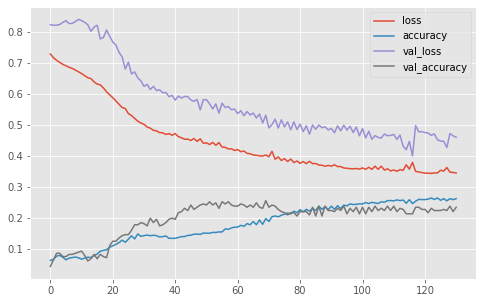

In [31]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.show()

In [32]:
model.save('lstm.h5')

# Prediction

In [33]:
forecast = model.predict(Xval)

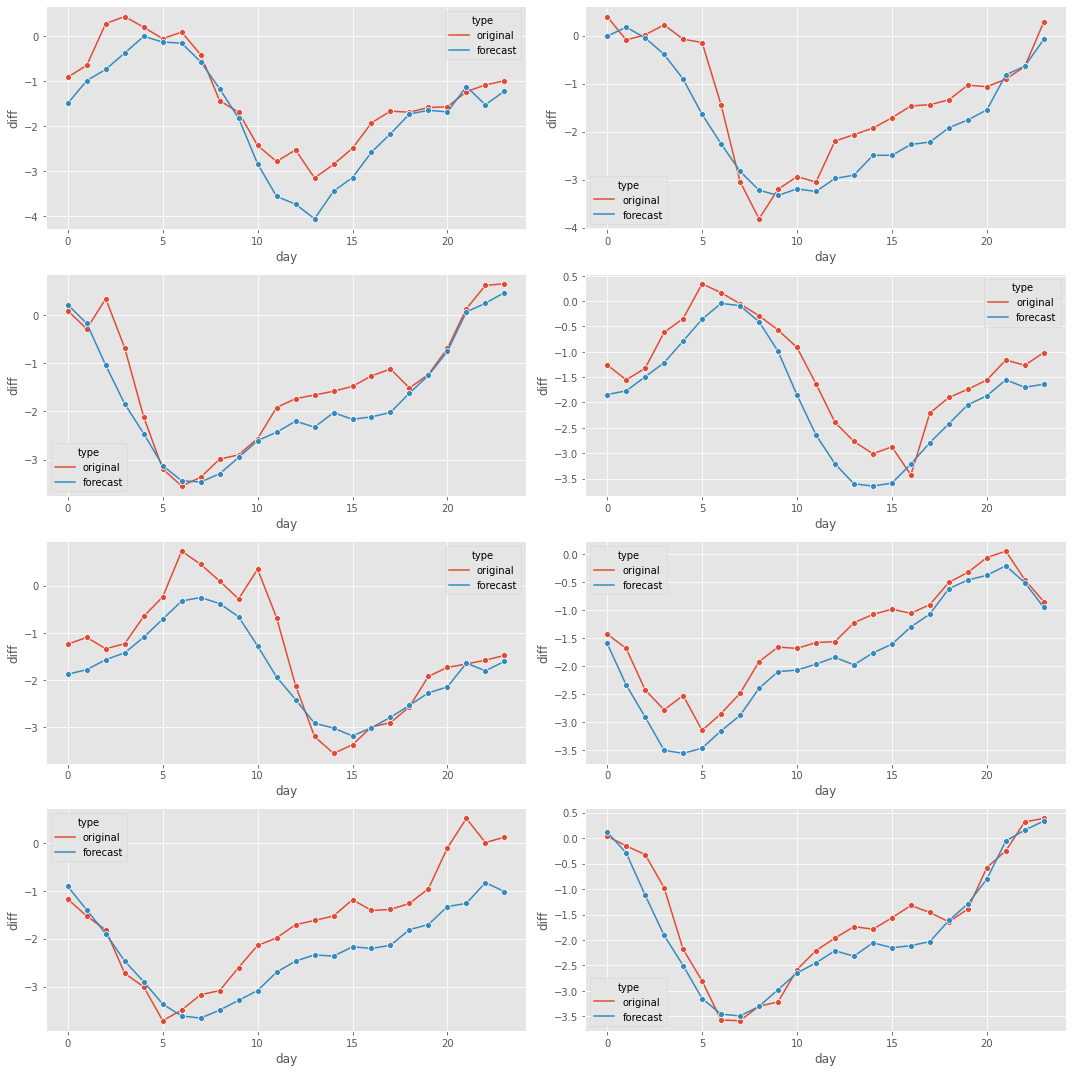

In [34]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

indexes = random.sample(range(len(forecast)), 8)

for i, index in enumerate(indexes):
    
    yhat = inverse_normalize(forecast[index].reshape(1, -1)).squeeze()
    y = inverse_normalize(Yval[index].reshape(1, -1)).squeeze()

    frame = pd.concat([
        pd.DataFrame({'day': range(len(y)), 'diff': y, 'type': 'original'}),
        pd.DataFrame({'day': range(len(y)), 'diff': yhat, 'type': 'forecast'})
    ]).reset_index()
    
    sns.lineplot(x='day', y='diff', ax = axes[i // 2, i % 2], data=frame, hue='type', marker='o')
    
plt.tight_layout()
plt.show()

In [39]:
import pandas as pd
import numpy as np
import traceback
import logging
from keras.models import load_model
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler(with_mean=False)

def normalize(data):
  return scaler.fit_transform(data)

def inverse_normalize(data):
  return scaler.inverse_transform(data)

# You should not modify this part.

def output(path, data):
    import pandas as pd

    df = pd.DataFrame(data, columns=["time", "action", "target_price", "target_volume"])
    df.to_csv(path, index=False)

    return


try:
    model = load_model('./lstm.h5')
    df_consumption = pd.read_csv("./consumption.csv")
    df_generation = pd.read_csv("./generation.csv")
    df_generation['time'] = pd.to_datetime(df_generation['time'])

    df_input = pd.DataFrame()
    df_input['time'] = df_generation['time']
    df_input['diff'] = df_generation['generation'] - df_consumption['consumption']
    df_input['hour'] = [timestamp.hour for timestamp in df_input['time']]
    df_input['month'] = [timestamp.month for timestamp in df_input['time']]

    # Creating the cyclical daily feature
    list_cos_hourly = [np.cos(x * (2 * np.pi / 24)) for x in df_input['hour']]
    list_sin_hourly = [np.sin(x * (2 * np.pi / 24)) for x in df_input['hour']]
    df_input['hour_index'] = list(map(lambda x, y: x + y, list_cos_hourly, list_sin_hourly))

    # Creating the cyclical yearly feature
    sec_in_a_year = 365.25 * 24 * 60 * 60
    list_cos_monthly = [np.cos(x.timestamp() * (2 * np.pi / sec_in_a_year)) for x in df_input['time']]
    list_sin_monthly = [np.sin(x.timestamp() * (2 * np.pi / sec_in_a_year)) for x in df_input['time']]
    df_input['month_index'] = list(map(lambda x, y: x + y, list_cos_monthly, list_sin_monthly))

    df_input.drop(['time', 'hour',	'month'], axis=1, inplace=True)
    df_input['diff'] = normalize( np.array(df_input['diff']).reshape(-1, 1) )

    pred = model.predict(df_input.to_numpy().reshape(-1, 168, 3))
    pred = inverse_normalize(pred).squeeze()

    data = []
    for i in range(24):
        if pred[i] > 0:
          data.append([df_generation.iloc[i]['time'] + timedelta(days=7), 'sell', 0.01, abs(pred[i])])
        else:
          data.append([df_generation.iloc[i]['time'] + timedelta(days=7), 'buy', 2.54, abs(pred)[i]])

except Exception as e:
    logging.error(traceback.format_exc())
    data = []
  
# data = [["2018-01-01 00:00:00", "buy", 2.5, 3],
#         ["2018-01-01 01:00:00", "sell", 3, 5]]

output("./out.csv", data)
